# Ranger Optimization + ImageWoof

This notebook will go over how to utilize the Ranger (RAdam + LookAhead) optimizer and a `fit_flat_cos` fit function to train on the ImageWoof dataset to recreate the results found in the ImageWoof competition.

In this notebook, I will show how to use the Ranger optimizer, create a scheduler to accomidate, and a custom mxresnet architechure utilizing a Simple Self Attention layer

First let's install the libraries. You need to restart your runtime after running this line

# Fastai v1

In [1]:
# import os
# os.getcwd() 

In [2]:
# import sys
# sys.path.append('~/anaconda3/pkgs/fastai-1.0.59-1/site-packages/fastai')
from pathlib import Path

from fastai import *
from ranger import *

In [3]:
import torch
torch.cuda.get_device_name(0)

'Quadro P6000'

In [4]:
#from mxresnet import *

In [5]:
# def get_data(size, woof, bs, workers=None):
#     if   size<=128: path = URLs.IMAGEWOOF if woof else URLs.IMAGENETTE
#     elif size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
#     else          : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
#     path = untar_data(path)

#     n_gpus = num_distrib() or 1
#     if workers is None: workers = min(8, num_cpus()//n_gpus)

#     return (ImageList.from_folder(path).split_by_folder(valid='val')
#             .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
#             .databunch(bs=bs, num_workers=workers)
#             .presize(size, scale=(0.35,1))
#             .normalize(imagenet_stats))

In [6]:
from fastai.vision import *

#src = untar_data(URLs.IMAGEWOOF)
src = Path('data/imagewoof/imagewoof')

n_gpus = num_distrib() or 1
nw = min(8, num_cpus()//n_gpus)

img_ls = ImageList.from_folder(src).split_by_folder(train='train', valid='val').label_from_folder()

#img_ls = img_ls.transform(([flip_lr(p=0.0)], []), size=(128,128))
img_ls = img_ls.transform(size=(128,128))

data =img_ls.databunch(bs=64, num_workers=nw).normalize(imagenet_stats)

#data.train_dl = data.train_dl.new(shuffle=False)
img_ls.train.y.items, img_ls.train.y.classes, img_ls.train.y[0]

(array([5, 5, 5, 5, ..., 2, 2, 2, 2]),
 ['n02086240',
  'n02087394',
  'n02088364',
  'n02089973',
  'n02093754',
  'n02096294',
  'n02099601',
  'n02105641',
  'n02111889',
  'n02115641'],
 Category n02096294)

In [7]:
data

ImageDataBunch;

Train: LabelList (12454 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02096294,n02096294,n02096294,n02096294,n02096294
Path: data/imagewoof/imagewoof;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02096294,n02096294,n02096294,n02096294,n02096294
Path: data/imagewoof/imagewoof;

Test: None

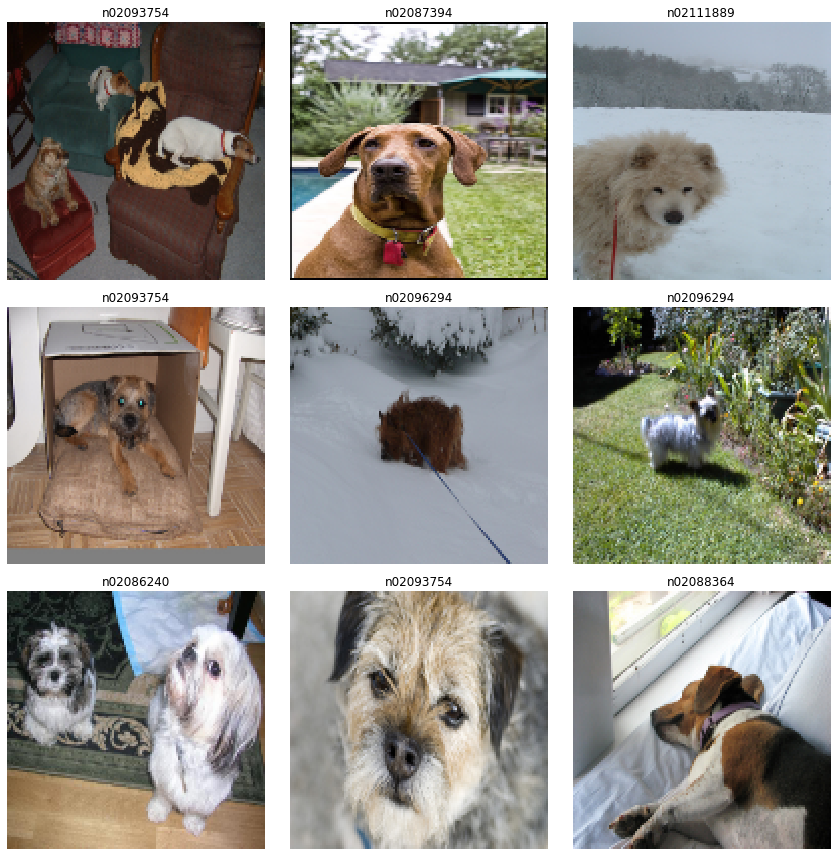

In [8]:
data.show_batch(3)

# Custom Architecture

We will be using a standard xResnet50 along with replacing each ReLU activation function with a CUDA implemented version of Mish, and a Simple Self Attention Layer

The code for Mish is from TomB's repo [here](https://gist.github.com/thomasbrandon/0dce1b088cf0fb20023394228645b1c1)

In [9]:
# import torch
# import torch.nn.functional as F

# class Mish(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x): 
        
#         x = x *( torch.tanh(F.softplus(x)))

#         return x

### MishJit

In [10]:
@torch.jit.script
def mish_jit_fwd(x):
    return x.mul(torch.tanh(F.softplus(x)))


@torch.jit.script
def mish_jit_bwd(x, grad_output):
    x_sigmoid = torch.sigmoid(x)
    x_tanh_sp = F.softplus(x).tanh()
    return grad_output.mul(x_tanh_sp + x * x_sigmoid * (1 - x_tanh_sp * x_tanh_sp))


class MishJitAutoFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return mish_jit_fwd(x)

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        return mish_jit_bwd(x, grad_output)


def mish_jit(x, inplace=False):
    # inplace ignored
    return MishJitAutoFn.apply(x)


class MishJit(nn.Module):
    def __init__(self, inplace: bool = False):
        super(MishJit, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return MishJitAutoFn.apply(x)

Now we need to use sdoria's implementation of the SimpleSelfAttention layer in xresnet and adjust for an activation function

In [11]:
#from fastai2.torch_core import *

import torch.nn as nn
import torch,math,sys
import torch.utils.model_zoo as model_zoo
from torch.nn.utils import spectral_norm 
from functools import partial

__all__ = ['XResNet', 'xresnet18', 'xresnet34', 'xresnet50', 'xresnet101', 'xresnet152']

# or: ELU+init (a=0.54; gain=1.55)
#act_fn = Mish()
act_fn = MishJit()


#Unmodified from https://github.com/fastai/fastai/blob/5c51f9eabf76853a89a9bc5741804d2ed4407e49/fastai/layers.py
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)

# Adapted from SelfAttention layer at https://github.com/fastai/fastai/blob/5c51f9eabf76853a89a9bc5741804d2ed4407e49/fastai/layers.py
# Inspired by https://arxiv.org/pdf/1805.08318.pdf
class SimpleSelfAttention(nn.Module):
    
    def __init__(self, n_in:int, ks=1, sym=False):#, n_out:int):
        super().__init__()
           
        self.conv = conv1d(n_in, n_in, ks, padding=ks//2, bias=False)      
       
        self.gamma = nn.Parameter(tensor([0.]))
        
        self.sym = sym
        self.n_in = n_in
        
    def forward(self,x):
        if self.sym:
            # symmetry hack by https://github.com/mgrankin
            c = self.conv.weight.view(self.n_in,self.n_in)
            c = (c + c.t())/2
            self.conv.weight = c.view(self.n_in,self.n_in,1)
                
        size = x.size()  
        x = x.view(*size[:2],-1)   # (C,N)
        
        # changed the order of mutiplication to avoid O(N^2) complexity
        # (x*xT)*(W*x) instead of (x*(xT*(W*x)))
        
        convx = self.conv(x)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
        xxT = torch.bmm(x,x.permute(0,2,1).contiguous())   # (C,N) * (N,C) = (C,C)   => O(NC^2)
        
        o = torch.bmm(xxT, convx)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
          
        o = self.gamma * o + x
        
          
        return o.view(*size).contiguous()        
        
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1,sa=False, sym=False):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        
        self.sa = SimpleSelfAttention(nf,ks=1,sym=sym) if sa else noop
        
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.sa(self.convs(x)) + self.idconv(self.pool(x)))
    

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))

class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000, sa = False, sym= False):
        
        stem = []
        sizes = [c_in,32,64,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2, sa = sa if i in[len(layers)-4] else False, sym=sym)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride, sa=False, sym=False):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, sa if i in [blocks -1] else False,sym)
              for i in range(blocks)])

def xresnet(expansion, n_layers, name, pretrained=False,  **kwargs):
    model = XResNet(expansion, n_layers, **kwargs)
    if pretrained: model.load_state_dict(model_zoo.load_url(model_urls[name]))
    return model

me = sys.modules[__name__]
for n,e,l in [
    [ 18 , 1, [2,2,2 ,2] ],
    [ 34 , 1, [3,4,6 ,3] ],
    [ 50 , 4, [3,4,6 ,3] ],
    [ 101, 4, [3,4,23,3] ],
    [ 152, 4, [3,8,36,3] ],
]:
    name = f'xresnet{n}'
    setattr(me, name, partial(xresnet, expansion=e, n_layers=l, name=name))

# Custom Fit Function

In [12]:
# FASTAI V1 VERSION
# By @muellerzr on the fastai forums:
# https://forums.fast.ai/t/meet-mish-new-activation-function-possible-successor-to-relu/53299/133       

from fastai.callbacks import *

def FlatCosAnnealScheduler(learn, lr:float=4e-3, tot_epochs:int=1, moms:Floats=(0.95,0.999),
                          start_pct:float=0.72, curve='cosine'):
    "Manage FCFit trainnig as found in the ImageNette experiments"
    n = len(learn.data.train_dl)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":
        curve_type=annealing_cos
    elif curve=="linear":
        curve_type=annealing_linear
    elif curve=="exponential":
        curve_type=annealing_exp
    else:
        raiseValueError(f"annealing type not supported {curve}")

    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr).schedule_hp('mom', moms[0])
    phase1 = TrainingPhase(batch_finish).schedule_hp('lr', lr, anneal=curve_type).schedule_hp('mom', moms[1])
    phases = [phase0, phase1]
    return GeneralScheduler(learn, phases)
                
def fit_fc(learn:Learner, tot_epochs:int=None, lr:float=defaults.lr,  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None, show_curve:bool=False)->None:
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr_range(lr)
    callbacks = listify(callbacks)
    callbacks.append(FlatCosAnnealScheduler(learn, lr, moms=moms, start_pct=start_pct, tot_epochs=tot_epochs))
    learn.fit(tot_epochs, max_lr, wd=wd, callbacks=callbacks)

# Training!

Now first we can find our learning rate:

In [13]:
opt_func = partial(Ranger, betas=(0.95,0.99), eps=1e-6)

learn = Learner(data, xresnet50(sa=True), wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy, top_k_accuracy]).to_fp16()

Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.74E-02


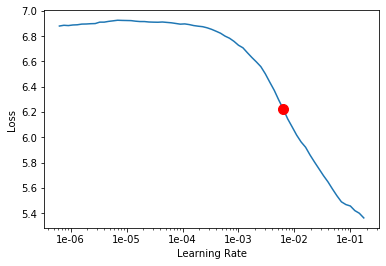

In [37]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

As we can see, the ideal learning rate is around 4e-3. Let's fit for five epochs. During the competition it was seen that after five epochs we could get anywhere between 74.6 - 78%. Let's see how we can do!

In [14]:
#del learn
learn = Learner(data, xresnet50(sa=True), wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy, top_k_accuracy]).to_fp16()

In [14]:
#run1:69.4%, run2:%72.3%, run3:70.3, run4:68.4, run5:69.6
fit_fc(learn, 5, 4e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.700892,2.656161,0.360000,0.848000,00:40
1,2.342111,2.609900,0.420000,0.876000,00:39
2,2.131618,2.090356,0.594000,0.966000,00:40
3,1.983508,2.194319,0.564000,0.952000,00:39
4,1.635994,1.797174,0.696000,0.966000,00:40


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


In [15]:
(69.4+72.3+70.3+68.4+69.6)/5

70.0

## Comparison with using Adam Optimizer

In [13]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)

In [14]:
learn = Learner(data, xresnet50(sa=True), wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy, top_k_accuracy]).to_fp16()

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 4.79E-03


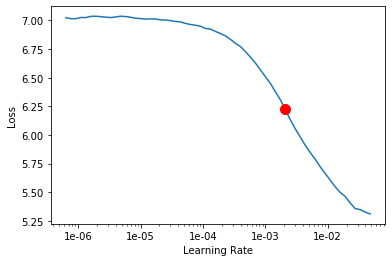

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
#del learn
fit_fc(learn, 5, 2e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.773052,2.807830,0.252000,0.804000,00:40
1,2.481352,2.572264,0.376000,0.874000,00:39
2,2.297245,2.394298,0.478000,0.922000,00:39
3,2.124582,2.199193,0.498000,0.946000,00:39
4,1.857197,1.926726,0.640000,0.958000,00:40


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
